In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import plotly.express as px
import pandas as pd
import numpy as np
import skfda
import os
import gc

In [4]:
os.chdir('..')

# Global variables

In [6]:
ID = 'event_id'
risk = 'risk'
time = 'time_to_tca'

# Binarize collision risk
To simplify the problem, we will use some clustering techniques to identify two groups acordin to the collision risk. This is motivated by the description of the datasets, which says that the events "*have been hand picked in order to over-represent high risk events and to create an interesting predictive model*".

In [11]:
df = pd.read_csv('data/raw/train_data.csv', usecols=[ID,time,risk])

In [13]:
print('Duplicated rows: {}'.format(df.shape[0]-df.drop_duplicates().shape[0]))

Duplicated rows: 0


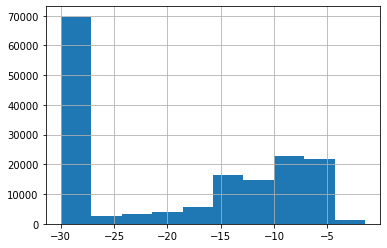

In [17]:
df[risk].hist()

### Evolution of the risk over time
Since the risk is computed at each moment, we need to decide which value we use for the clustering. The most sensible idea seems to be to use the last one, but we will check first the evolution over time of the risk to see how big the variance is.

In [62]:
fig = px.line(df.head(500), x=time, y=risk, line_group=ID, width=700, height=400)
fig.show()

Some things we can assume from this graph: 
- there is some risk threshold in -10, since all the objects with risk higher than -10 in the two previous days have a quick change. This threshold if used also in the paper to distinguish between high-probability chollisions. So it seems more suitable to cluster the risk after removing the information of the last two days, to use the risk before any manoeuvre.
- the values -30 can be considered as zero risk. So maybe we could remove all the -30 from the dataset, if we asume that that's the value after the manoeuvre.
- For some events it seems that a manoeuvre was performed much earlier, since there is an abroupt change in the risk to -30, or it could be that there was a mistake in the computations for the early days.

We can also draw the mean risk among all the events (per day), to get an idea of the shape of the curves.

In [72]:
df['day'] = df[time].round().astype(int)
px.line(df.groupby('day')[risk].mean().to_frame().reset_index(), x='day', y=risk, width=700, height=400)

### Variables to do the clustering
Let's remove the -30 from the data to have a more detailed look to the risk.

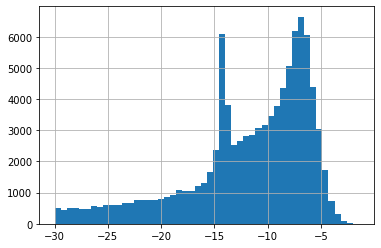

In [24]:
df[df[risk]!=-30][risk].hist(bins=50)

It seems there is indeed two modes in this graph, which could correspond with the two groups. Let's look at :
- the value 2 days before the TCA 
- the last not -30 value
- the maximum value per event
- the last value in genera, which is used to compute the "final risk" according to the page: *the final risk which is computed in the last CDM of the time series (i.e. the risk value in the last row of each collision event)*

In [45]:
df['diff2d'] = abs(df[time]-2)

In [107]:
def _get_2d(df_group):
    return df_group[df_group['diff2d']==df_group['diff2d'].min()][risk].values[0]
df_risks = df.groupby(ID).apply(_get_2d).to_frame().reset_index().rename(columns={0: 'risk2d'})
df_risks.sample()

event_id  risk2d
3986      3986   -30.0

In [138]:
def _get_not30(df_group):
    df_not30 = df_group[df_group[risk]!=-30].sort_values(time)
    if len(df_not30)>0:
        return df_not30.iloc[0][risk]
    else:
        return np.nan
df_risks = pd.merge(df_risks, 
                    df.groupby(ID).apply(_get_not30).to_frame().reset_index().rename(columns={0: 'risk_not30'}), 
                    on=ID)

In [140]:
df_risks.sample()

event_id  risk2d  risk_not30
2999      2999   -30.0   -7.324313

In [143]:
df_group=df.loc[df[ID]==0]

In [149]:
df_risks = pd.merge(df_risks, 
                    df.groupby(ID)[risk].max().to_frame().reset_index().rename(columns={'risk': 'risk_max'}),
                    on=ID)
df_risks.sample()

event_id    risk2d  risk_not30  risk_max
4072      4072 -6.924818     -6.9859 -6.669181

In [172]:
def _get_last(df_group):
    return df_group.sort_values(time).iloc[0][risk]

df_risks = pd.merge(df_risks, 
                    df.groupby(ID).apply(_get_last).to_frame().reset_index().rename(columns={0: 'risk_last'}), 
                    on=ID)

In [173]:
df_risks.sample()

event_id    risk2d  risk_not30  risk_max  risk_last
12729     12729 -5.342562   -5.753994 -5.321118      -30.0

Let's draw the histograms for each of the risks.

In [174]:
for c in ['risk2d', 'risk_not30', 'risk_max', 'risk_last']:
    hist = px.histogram(df_risks, x=c, width=700, height=400)
    hist.show()

Let's draw the same histograms but removing all the -30s.

In [175]:
for c in ['risk2d', 'risk_not30', 'risk_max', 'risk_last']:
    hist = px.histogram(df_risks[df_risks[c]!=-30], x=c, width=700, height=400)
    hist.show()

So it seems the one that better discriminates between the two groups in the maximum. Besides, it looks like they tried to include only events whose maximum risk was over -15. So we could **discard all the events under than risk** to remove some noise.

### Clustering: 2-means
We will perform the clustering using the maximum of the risk, but only for the events with value higher than -15.

In [205]:
print('{0:0.2f}% of the events have maximum risk less than -15'.format(df_risks[df_risks['risk_max']<-15].shape[0]/df_risks.shape[0]*100))
print('After discarding the events whose max risk is -30, {0:0.2f}% of the events have maximum risk less than -15'.format(
    df_risks[(df_risks['risk_max']!=-30) & (df_risks['risk_max']<-15)].shape[0]/df_risks[df_risks['risk_max']!=-30].shape[0]*100))

9.23% of the events have maximum risk less than -15
After discarding the events whose max risk is -30, 1.78% of the events have maximum risk less than -15


In [176]:
df_risks['risk_max_cut'] = df_risks['risk_max']
df_risks.loc[df_risks['risk_max_cut']<-15, 'risk_max_cut'] = np.nan

In [177]:
# Because k-means needs two dimensions...
df_risks['const'] = 1

In [178]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_risks[['risk_max_cut', 'const']].dropna())
kmeans.cluster_centers_

array([[ -6.96358427,   1.        ],
       [-12.76188361,   1.        ]])

As expected, the centers (-6.96 and -12.76) correspond to the two modes of the histogram. Besides, in the scoring all the events with last risk higher than 6 are considered as high risk, which would mean all the ones that are on the right of the mode.

In [211]:
df_risks['risk_binary'] = df_risks['risk_max_cut'].apply(lambda x: -1 if np.isnan(x) else abs(kmeans.predict(np.array([[x,1]]))[0]-1))

In [212]:
df_risks.sample()

event_id  risk2d  risk_not30  risk_max  risk_last  risk_max_cut  const  \
6331      6331   -30.0   -8.772113 -8.772113      -30.0     -8.772113      1   

      risk_binary  
6331            1

In [213]:
df_risks.groupby('risk_binary').size()

risk_binary
-1    1214
 0    4611
 1    7329
dtype: int64

In [214]:
px.histogram(df_risks, x='risk_max', color='risk_binary', width=700, height=400)

2-means doesn't seem to be the best option, since the first mode has a lower variance than the second one, and that's not captured by this technique. However, it seems to get the division around -10.

In [215]:
df_risks.groupby('risk_binary')['risk_max'].min()

risk_binary
-1   -30.000000
 0   -14.999132
 1    -9.862646
Name: risk_max, dtype: float64

So we are going to use the thresholds -15 and -10 to create the dummy variables in the preprocessing.